In [2]:
import pandas as pd
import os
import glob
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
import matplotlib.pyplot as plt
from IPython.display import HTML, display, Markdown
import seaborn as sns

from metadata.etfs import etfs_large, etfs_small
from utils.conn_data import load_pickle

plt.style.use('seaborn')

In [3]:
outputs_path = os.path.join(os.path.dirname(os.getcwd()), "src", "data", "outputs")
des = pd.read_csv(os.path.join(os.getcwd(), 'data', 'utils', 'fredmd_description.csv'), sep=';')

fs_methods = ["lasso", "multivariate-granger", "pairwise-granger", "var-lingam"]
metric_names = ["stability", "mse", "mae"]
etf_focus = None
stability_threshold = 0.8
plot_ts = False

In [4]:
warnings.simplefilter("ignore")


all_metrics = []
all_rolling_metrics = []
all_stability = []
for fs in fs_methods:

    if plot_ts:
        display(Markdown(f"## {fs}"))

    # list results files with glob
    results_files = glob.glob(os.path.join(outputs_path, fs, "etfs_macro_large", "*.pickle"))

    # load results files
    stability = []
    metrics = []
    for file in results_files:
        etf = file.split(fs)[-1].split("/")[-1].split("_")[0]

        if (etf_focus != etf) and (etf_focus is not None):
            continue
        else:
            pass

        obj = load_pickle(path=file)

        # plot predictions
        predictions_df = obj['predictions']
        predictions_2020_df = predictions_df.loc["2020-01-01":"2020-12-01"]

        if plot_ts:
            fig, ax = plt.subplots(figsize=(10, 5))
            ax.set_title(label=f'OOS Predictions for {etf}', fontsize=15)
            ax.plot(pd.to_datetime(predictions_df.index), predictions_df["prediction"], label="predictions")
            ax.plot(pd.to_datetime(predictions_df.index), predictions_df["true"], label="true")
            plt.xlabel("Date")
            plt.ylabel("Returns")
            plt.legend(loc='best', fontsize=10)   
            plt.show()

        # compute rolling mse
        rolling_metric_df = predictions_df.copy()
        rolling_metric_df["diff"] = rolling_metric_df["prediction"] - rolling_metric_df["true"]

        # rolling mse
        rolling_metric_df["rolling_mse"] = rolling_metric_df["diff"].pow(2).rolling(12).mean()
        rolling_metric_df = rolling_metric_df[["rolling_mse"]]

        # add info
        rolling_metric_df["fs"] = fs
        rolling_metric_df["etf"] = etf

        # melt
        melt_rolling_metric_df = rolling_metric_df.reset_index().melt(["date", "fs", "etf"])

        # compute forecast metrics
        mse = mean_squared_error(predictions_df["true"], predictions_df["prediction"])
        mae = mean_absolute_error(predictions_df["true"], predictions_df["prediction"])
        mse_2020 = mean_squared_error(predictions_2020_df["true"], predictions_2020_df["prediction"])
        mae_2020 = mean_absolute_error(predictions_2020_df["true"], predictions_2020_df["prediction"])

        # compute cluster stability metrics
        parents_of_target_df = obj["parents_of_target"]
        
        tot = len(parents_of_target_df["date"].unique())
        stability_df = (parents_of_target_df.fillna(0).groupby(["cluster"]).sum()[["value"]] / tot).sort_values(by="value", ascending=False)
        stability_df = pd.concat({etf: stability_df}, names=['etf'])
        stability.append(stability_df)

        stability_measure = (stability_df).sum().iloc[0] / stability_df.shape[0]
        metrics_df = pd.DataFrame({
            "fs": fs, 
            "etf": etf, 
            "mse": [mse],
            "mae": [mae], 
            "mse_2020": [mse_2020], 
            "mae_2020": [mae_2020],
            "stability": stability_measure})
        metrics.append(metrics_df)
        all_rolling_metrics.append(melt_rolling_metric_df)
    
    all_metrics.append(pd.concat(metrics).set_index(["fs", "etf"]))
    all_stability.append(pd.concat(stability))
all_metrics_df = pd.concat(all_metrics)
all_rolling_metrics_df = pd.concat(all_rolling_metrics)
melted_all_metrics_df = all_metrics_df.reset_index().melt(id_vars=["fs", "etf"])

In [5]:
parents_of_target_df.loc[(parents_of_target_df["date"] >= "2020-01-01")|(parents_of_target_df["date"] >= "2020-01-01")]

,date,variable,value,fred,cluster
0,2004-01-31,XLI(t-1),1,XLI,NaN
1,2004-01-31,TOTRESNS(t-1),1,TOTRESNS,4.0
2,2004-01-31,AWOTMAN(t-1),1,AWOTMAN,6.0
3,2004-01-31,IPMAT(t-1),1,IPMAT,2.0
4,2004-01-31,USWTRADE(t-1),1,USWTRADE,7.0
...,...,...,...,...,...
15,2022-12-31,TB3MS(t-1),1,TB3MS,19.0
16,2022-12-31,EXJPUSx(t-1),1,EXJPUSx,0.0
17,2022-12-31,BAAFFM(t-1),1,BAAFFM,11.0
18,2022-12-31,WPSID62(t-1),1,WPSID62,5.0


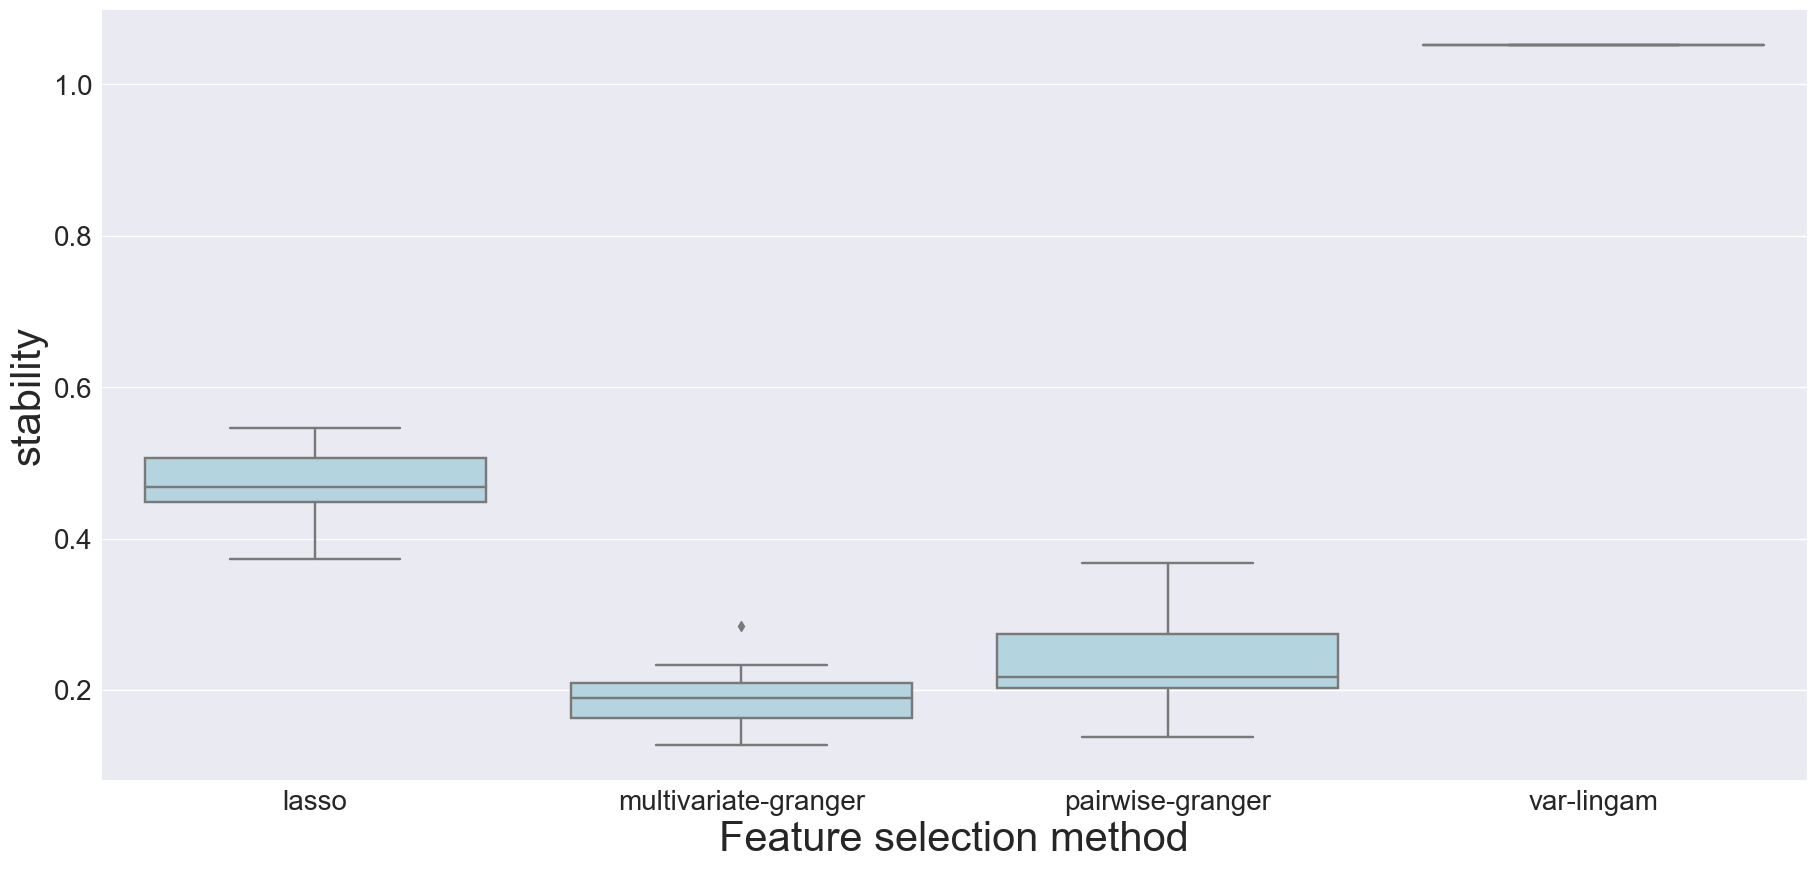

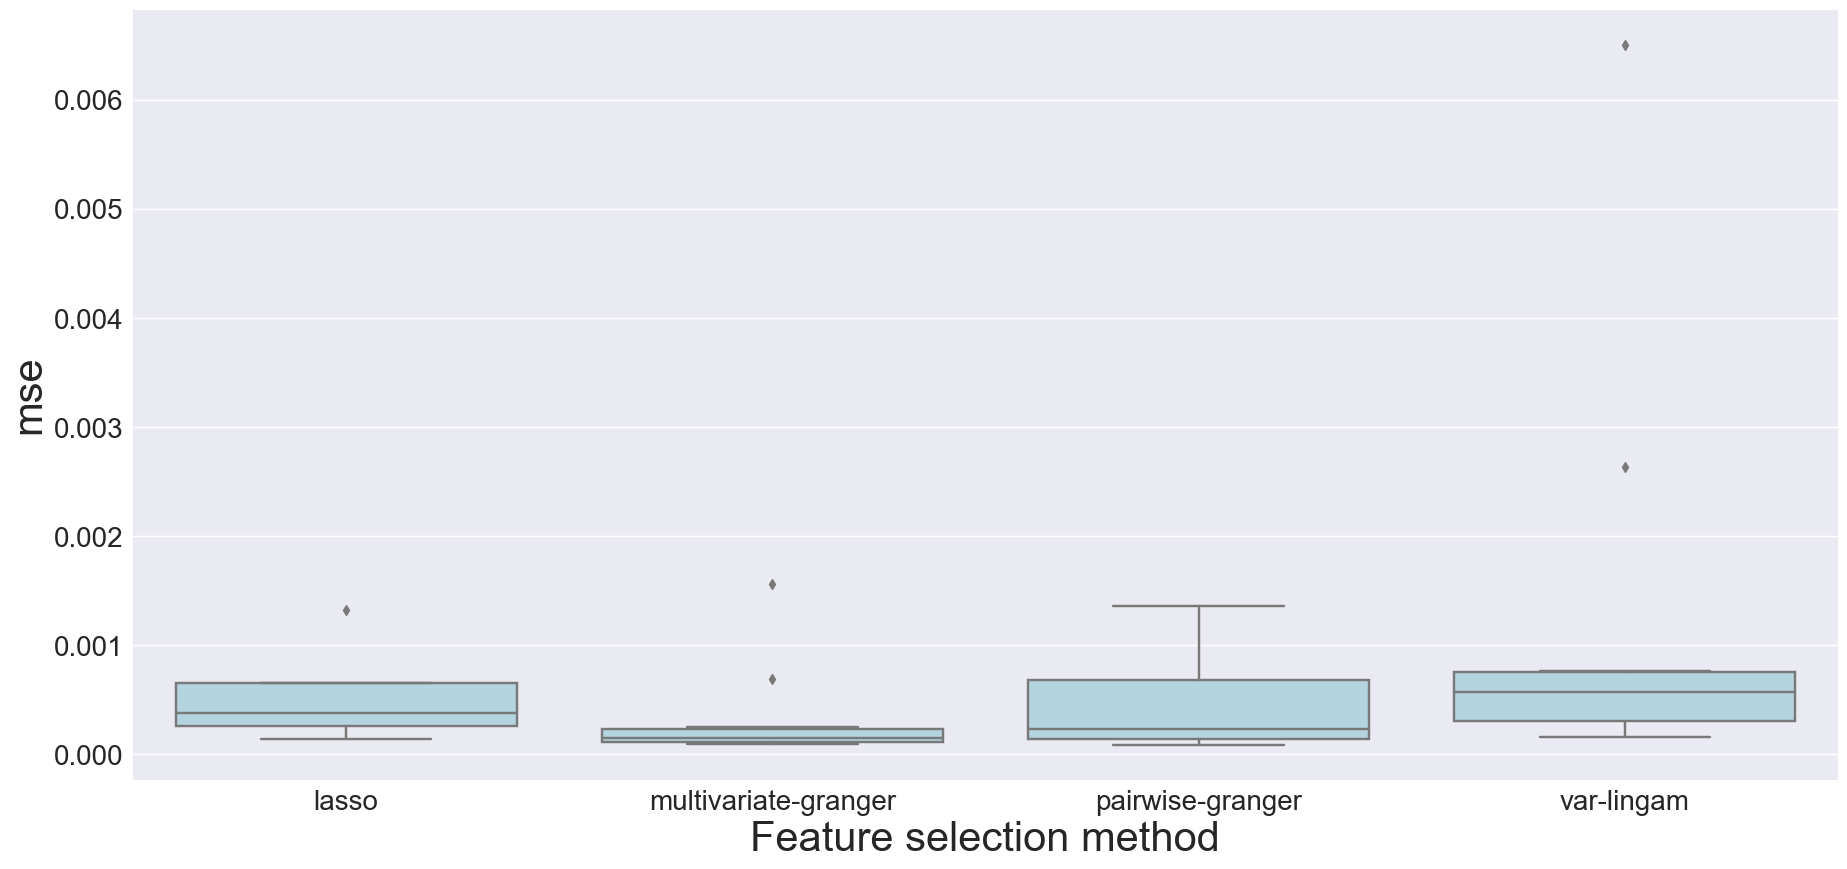

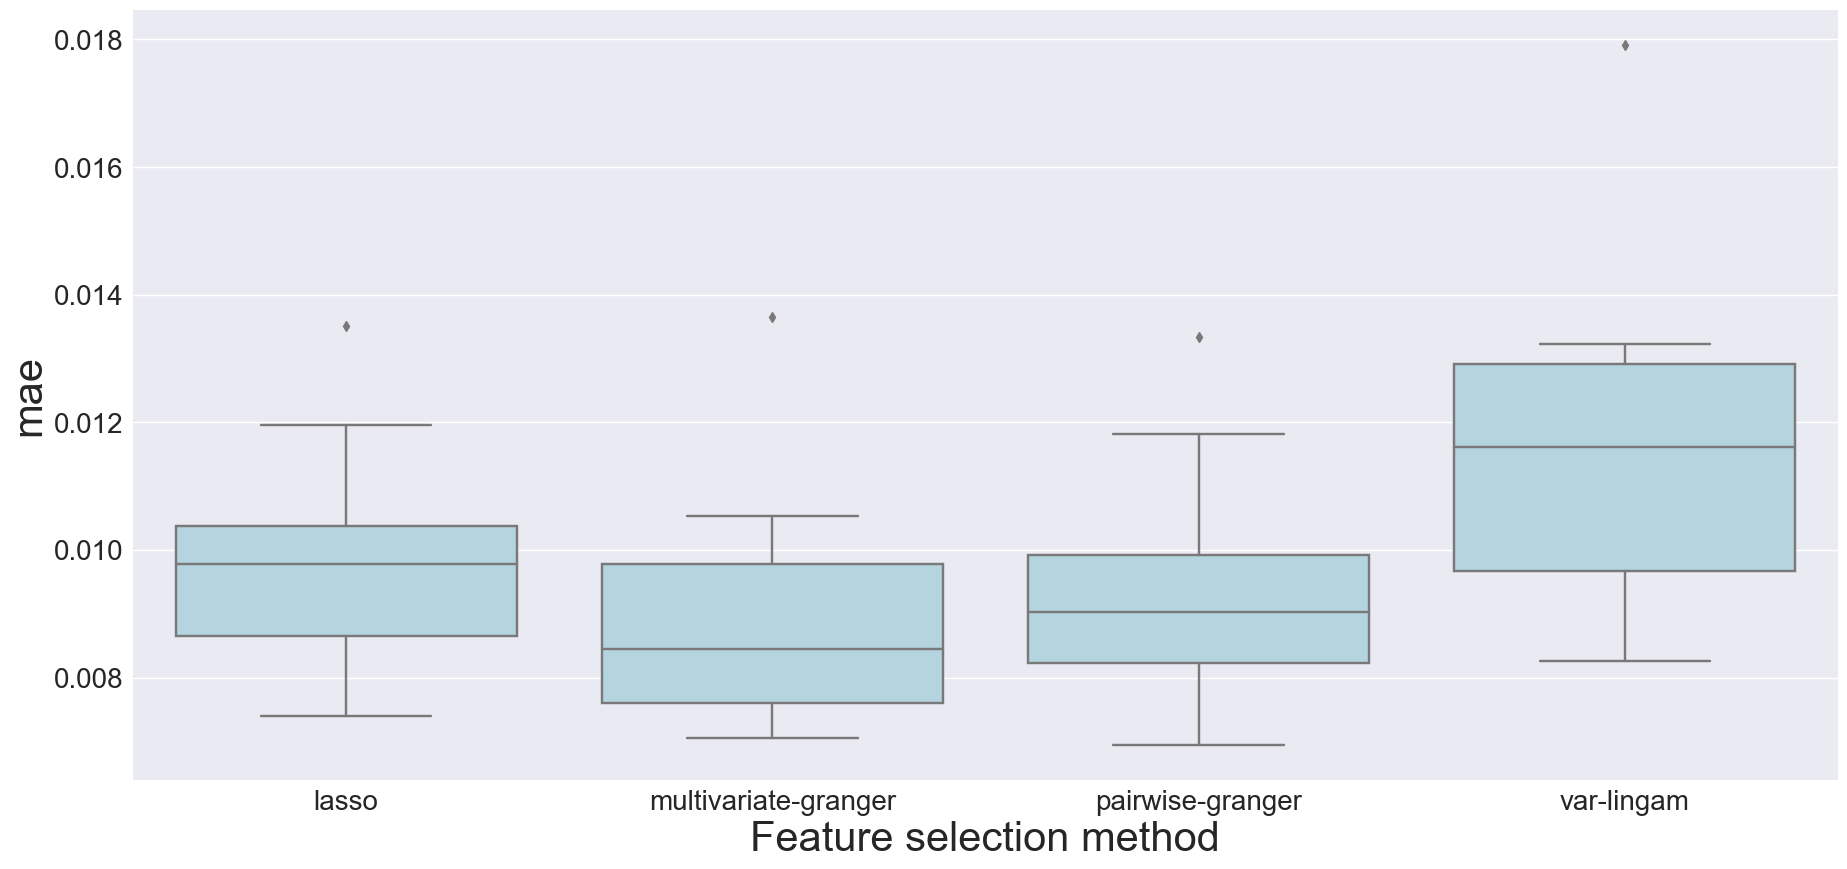

In [8]:
metric_name = "mse"
for m in metric_names:
    boxplot_df = melted_all_metrics_df.loc[(melted_all_metrics_df["variable"] == m)].drop(["variable"], axis=1)

    fig, ax = plt.subplots(figsize=(22, 10))
    sns.boxplot(x="fs", y='value',data=boxplot_df, ax=ax, color='lightblue')
    ax.set_ylabel(m, fontsize=30)
    ax.set_xlabel("Feature selection method", fontsize=30)
    ax.tick_params(axis="x", labelsize=20)
    ax.tick_params(axis="y", labelsize=20)
    # ax.legend(loc="best",fontsize=15)
    # fig.savefig('img/oos_auc_fs_methods_distr.png')

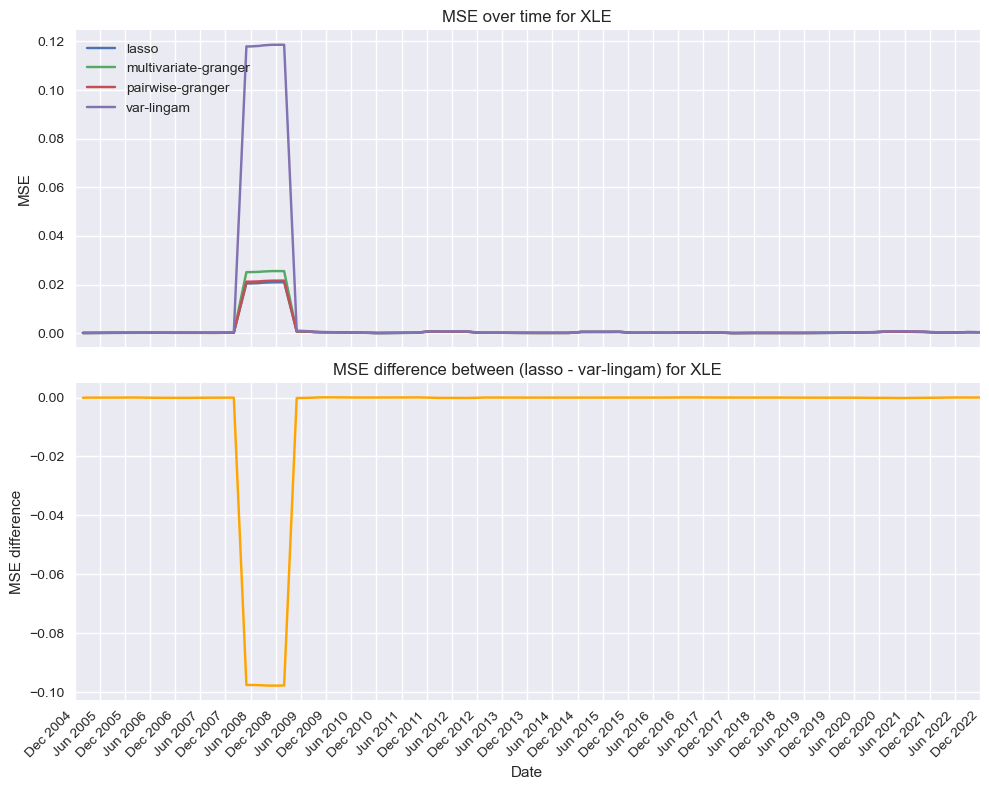

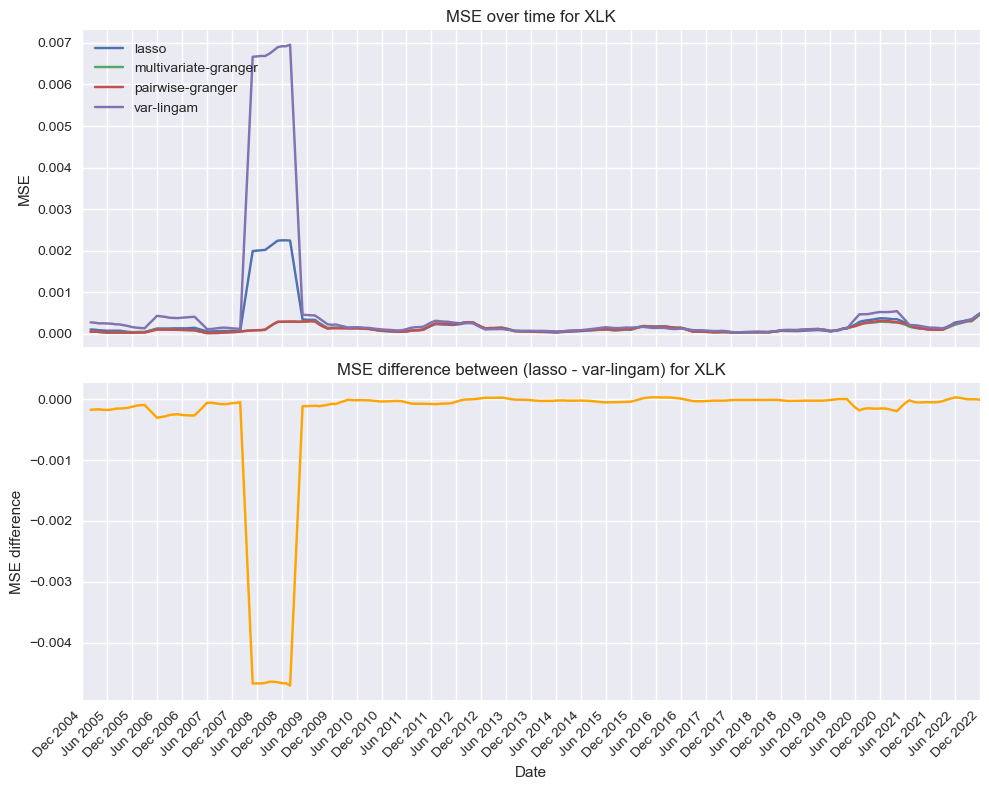

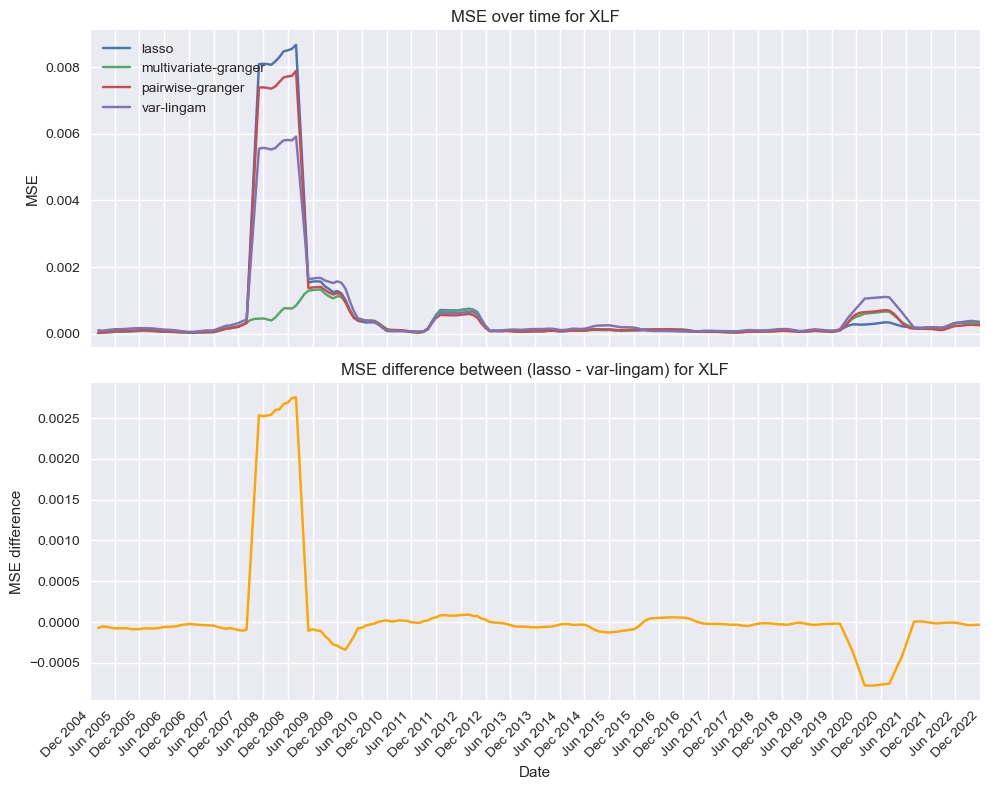

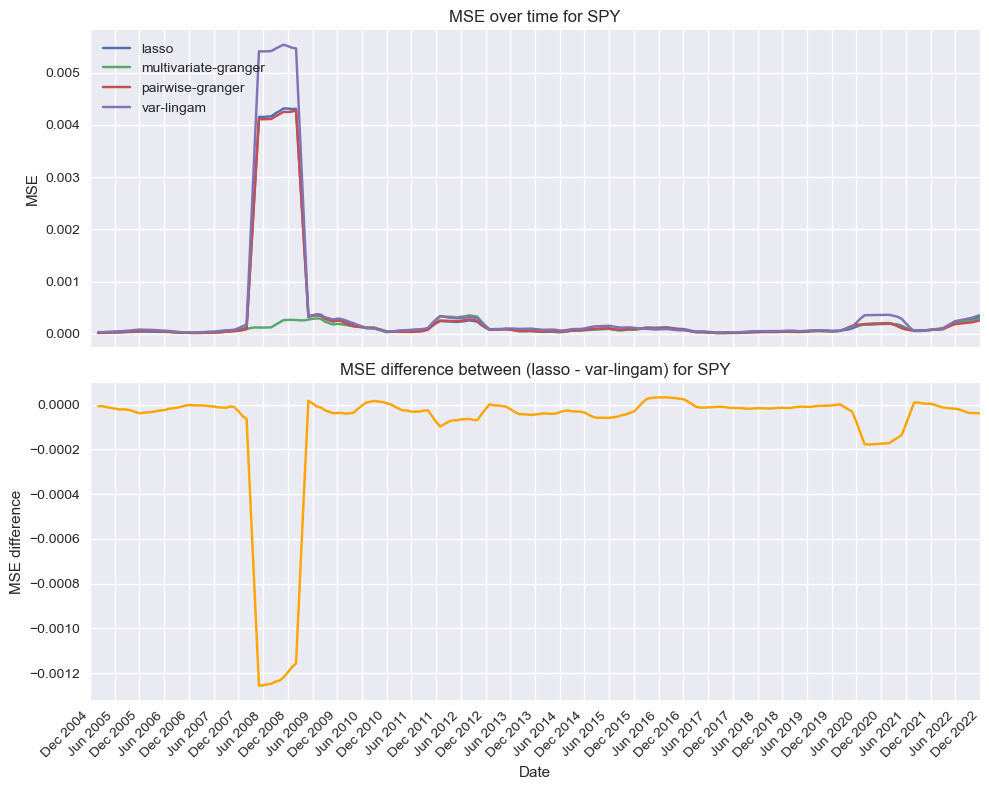

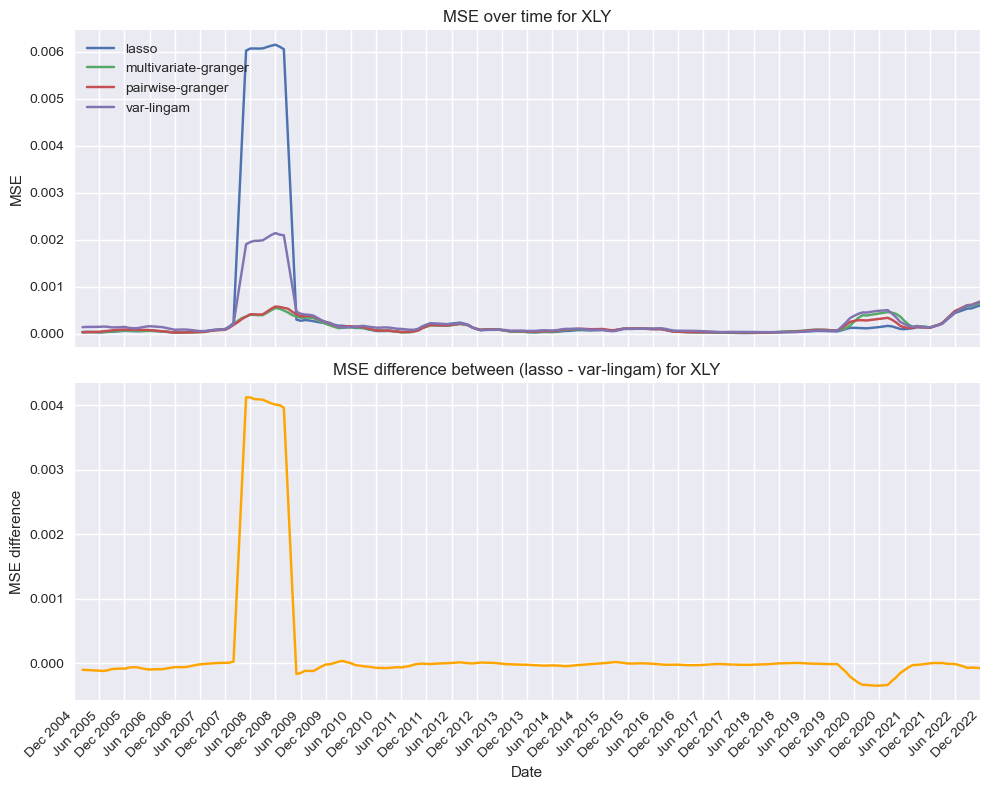

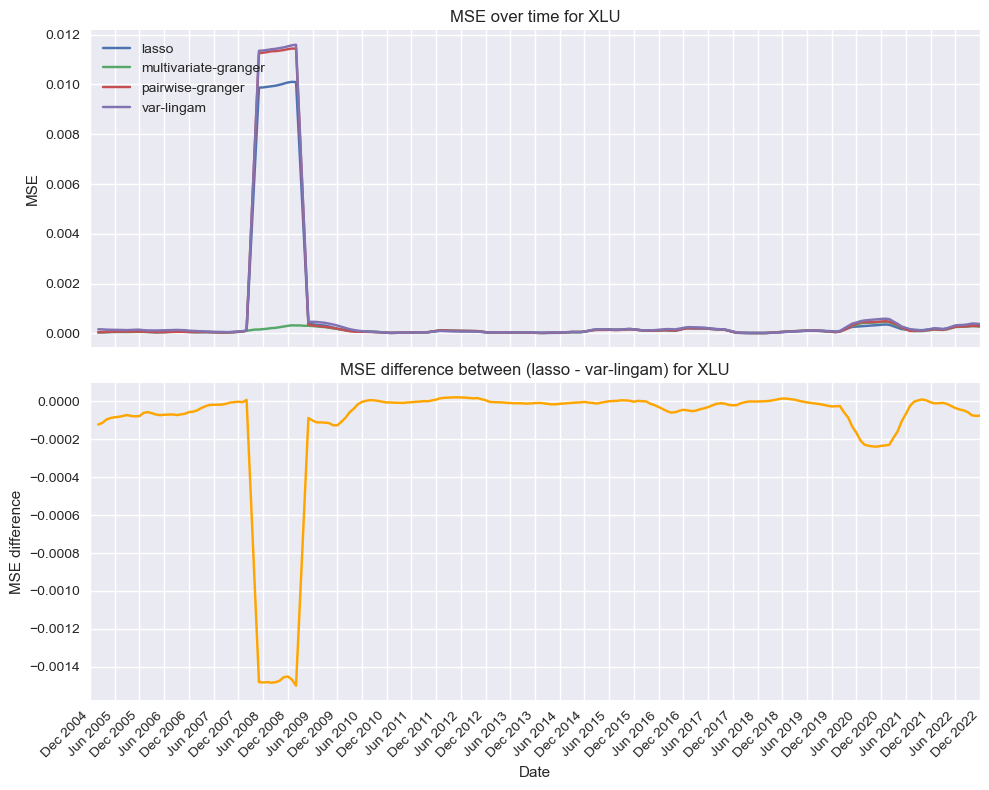

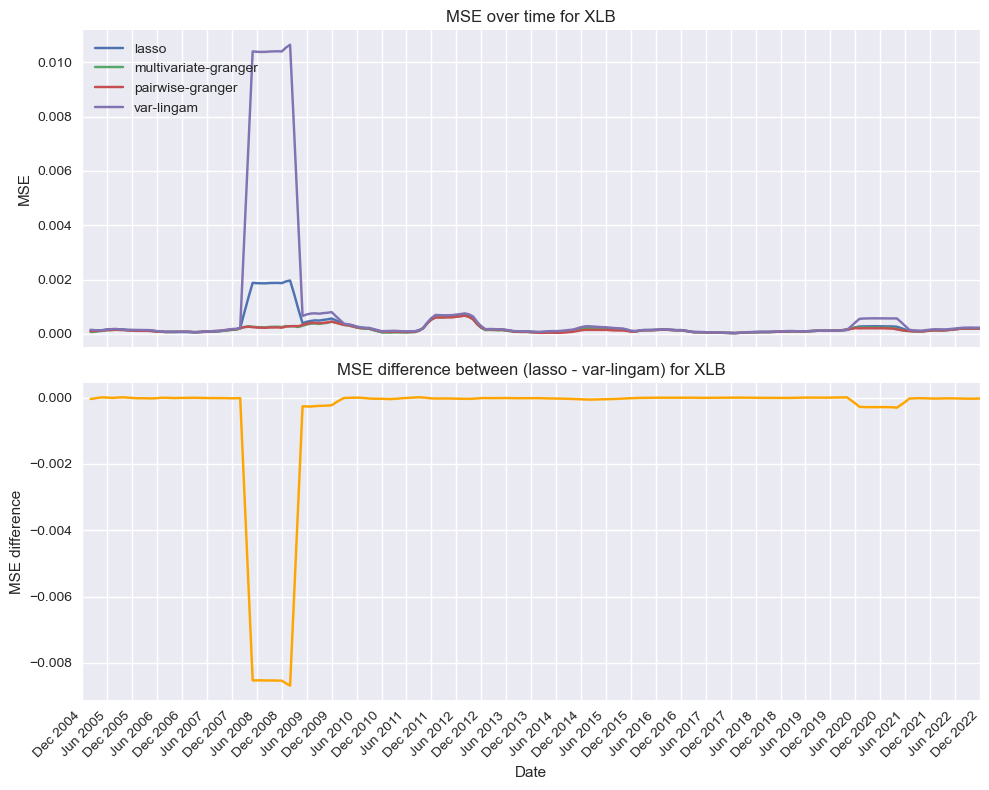

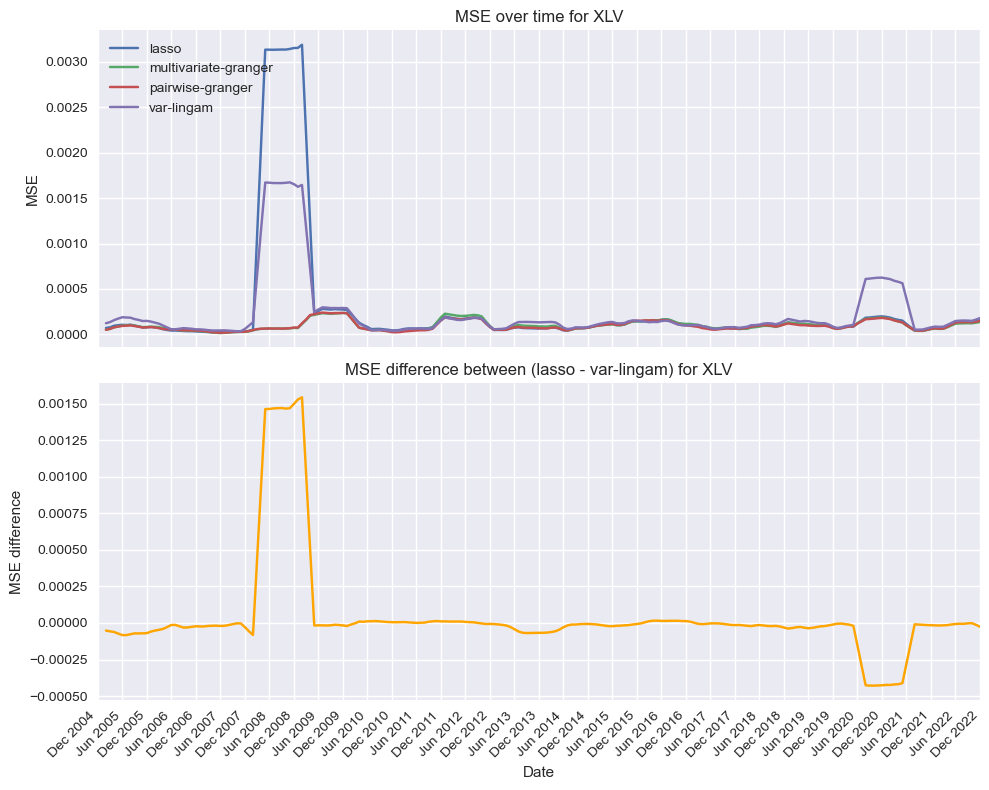

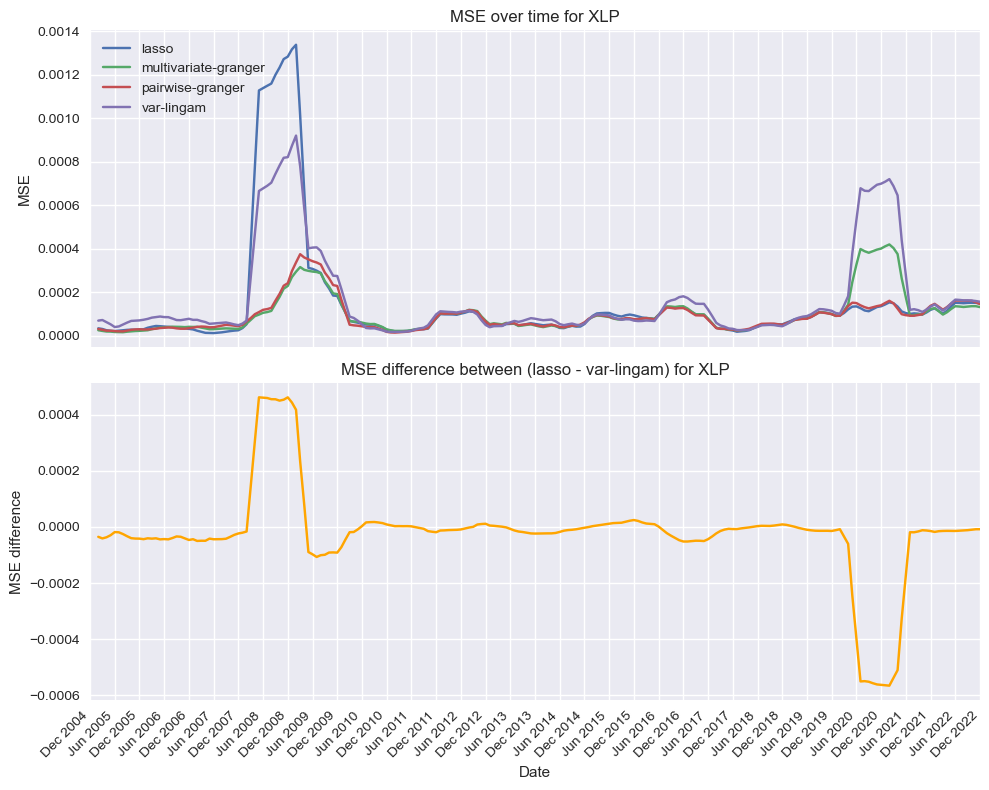

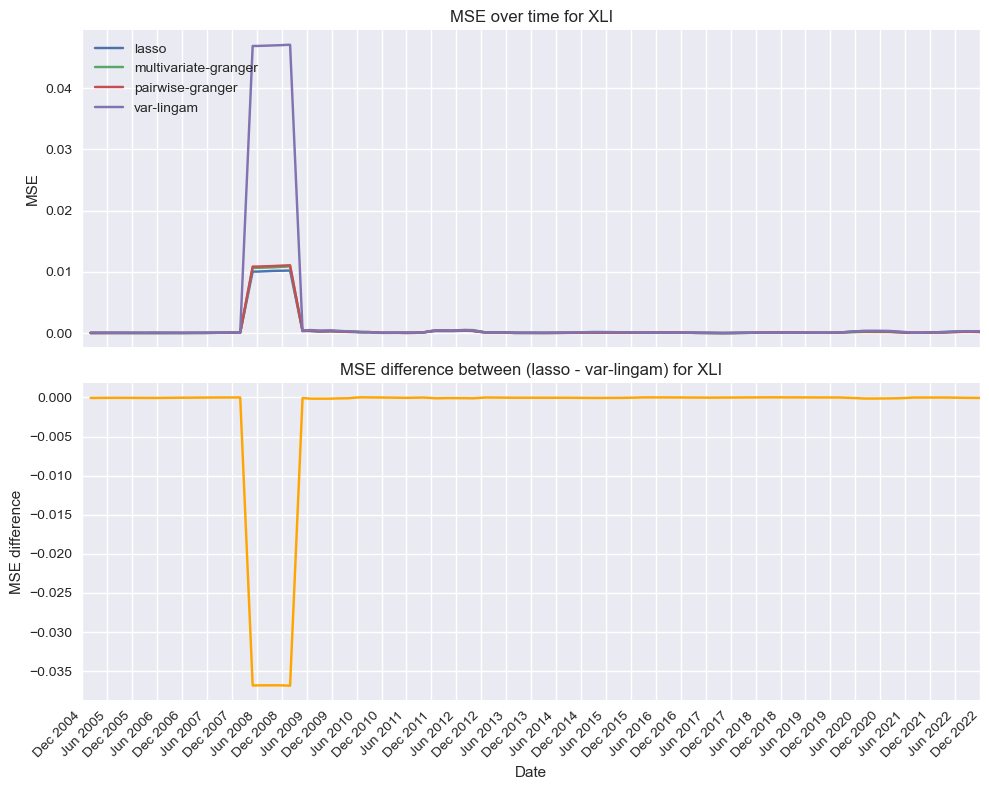

In [35]:
# SPY, XLP, XLK, XLY, XLF, XLB, XLI 

for etf in all_rolling_metrics_df["etf"].unique():
    etf_rolling_metrics_df = all_rolling_metrics_df.loc[(all_rolling_metrics_df["etf"] == etf)].pivot_table(index=["date"], columns=["fs"], values=["value"])
    etf_rolling_metrics_df.columns = etf_rolling_metrics_df.columns.droplevel()
    etf_rolling_metrics_df = etf_rolling_metrics_df.rolling(3).mean()
    etf_rolling_metrics_df["diff_lasso_var-lingam"] = etf_rolling_metrics_df["lasso"] - etf_rolling_metrics_df["var-lingam"]

    # Plotting
    fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # Plotting on the upper subplot
    etf_rolling_metrics_df.drop(["diff_lasso_var-lingam"], axis=1).plot(ax=axs[0])
    axs[0].set_title(f'MSE over time for {etf}')
    axs[0].set_ylabel('MSE')
    axs[0].legend(loc='upper left')

    # Plotting on the lower subplot
    etf_rolling_metrics_df["diff_lasso_var-lingam"].plot(ax=axs[1], color='orange')
    axs[1].set_title(f'MSE difference between (lasso - var-lingam) for {etf}')
    axs[1].set_xlabel('Date')
    axs[1].set_ylabel('MSE difference')

    # Adding months and years to the index of the plot
    tick_positions = etf_rolling_metrics_df.index[::6]  # Show every 6th date
    axs[1].set_xticks(tick_positions)
    axs[1].set_xticklabels(tick_positions.strftime('%b %Y'), rotation=45, ha='right')

    # Adjust layout for better visualization
    plt.tight_layout()

    # Show the plot
    plt.show()

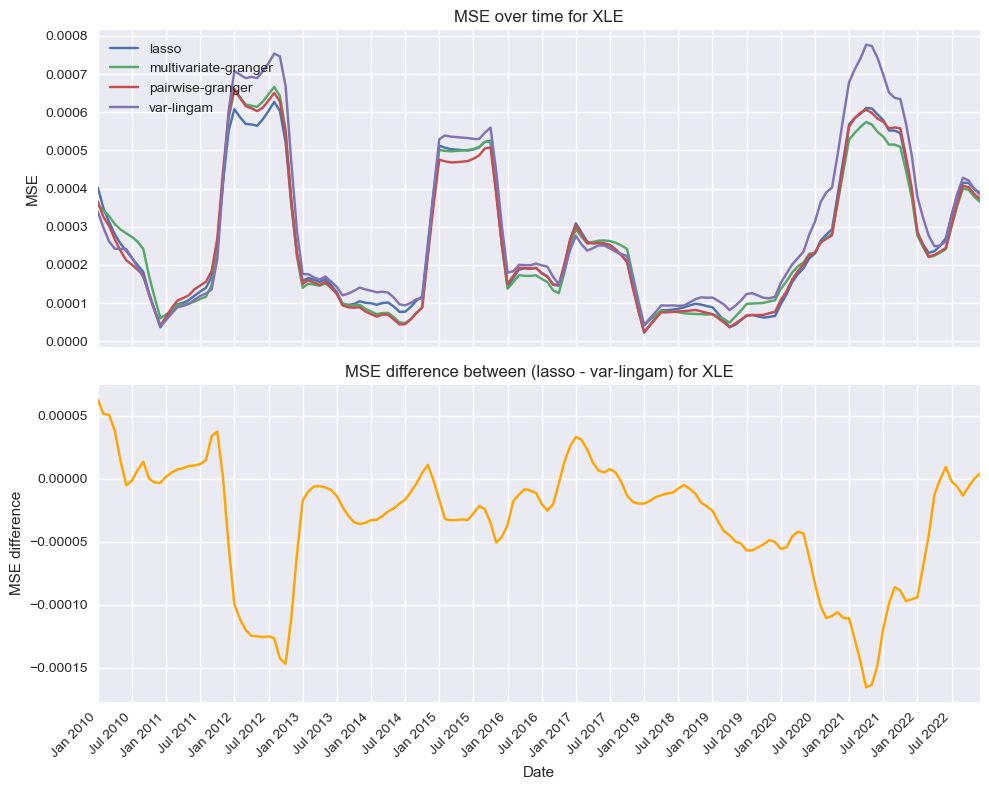

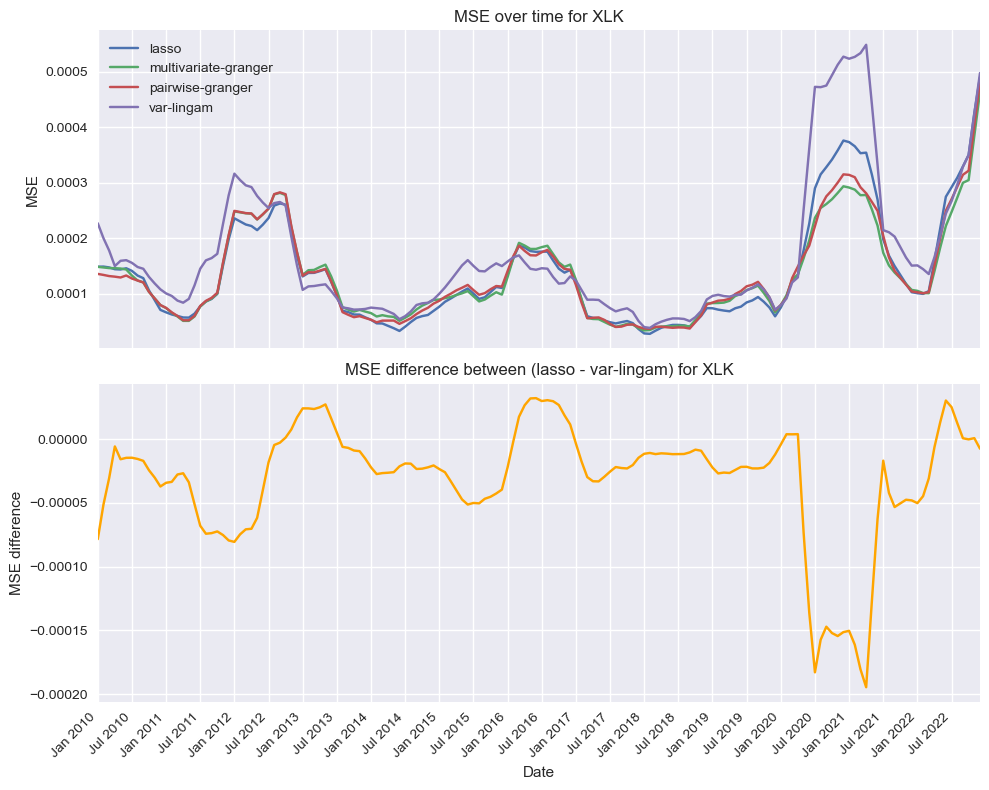

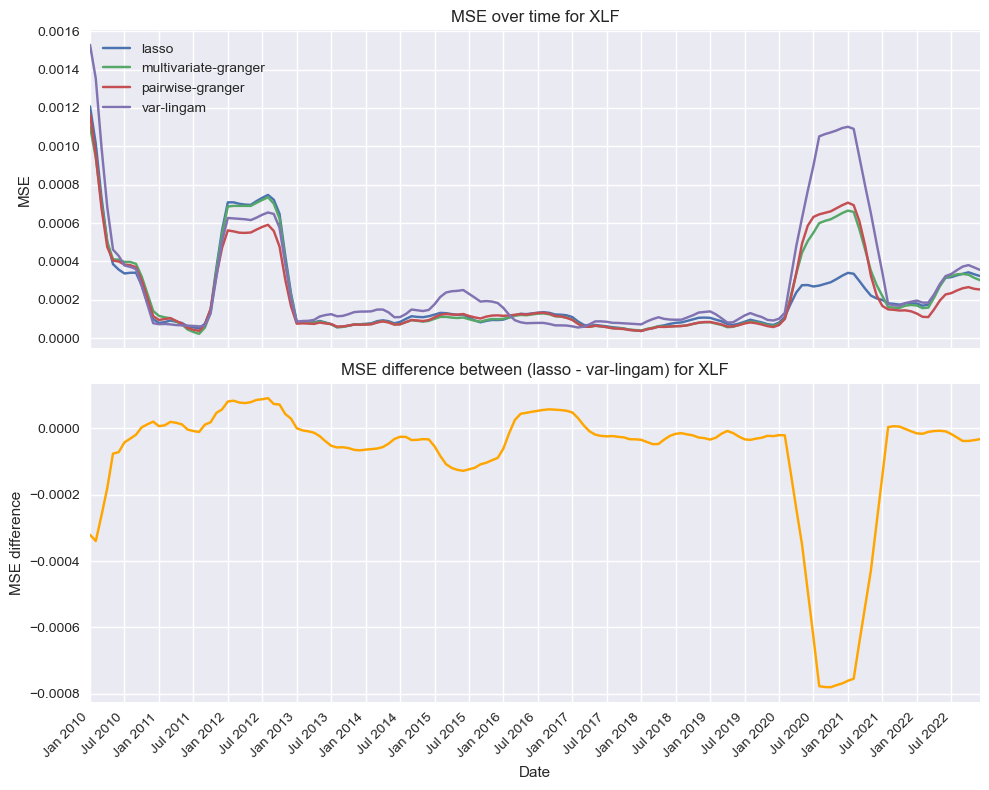

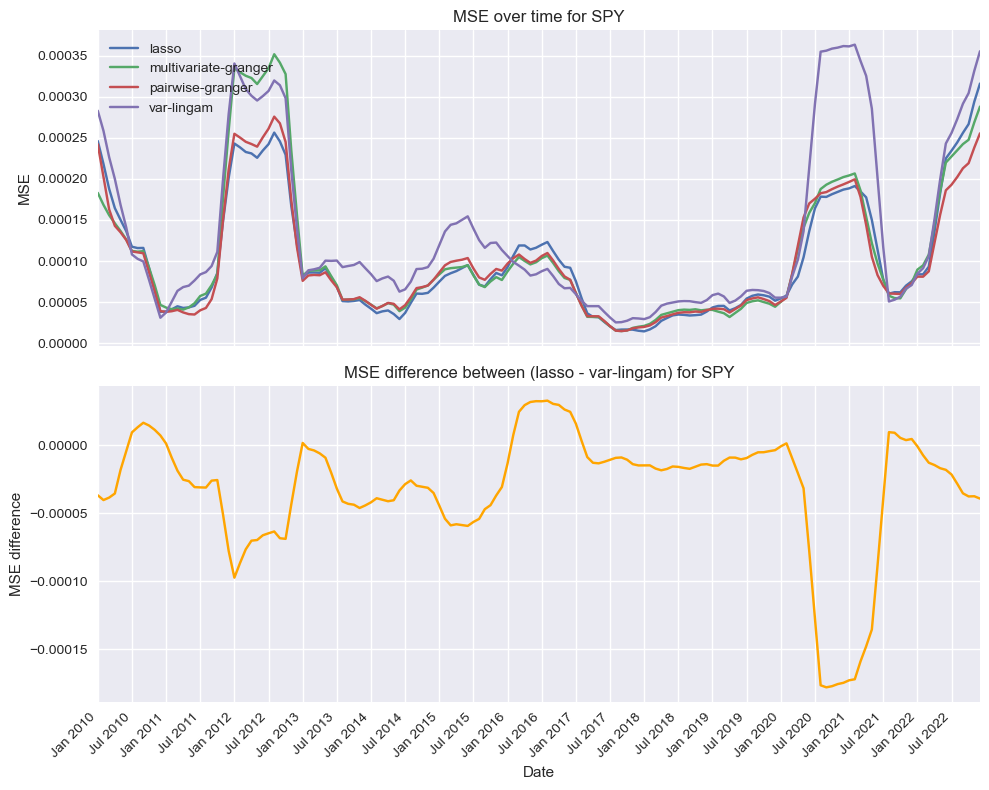

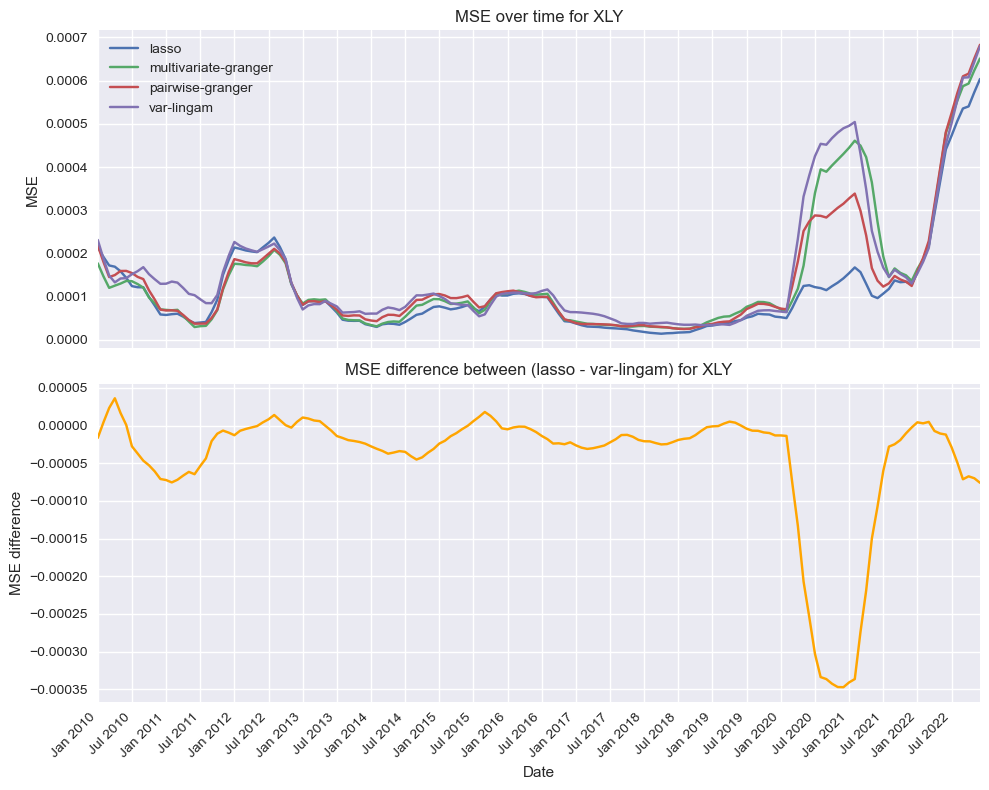

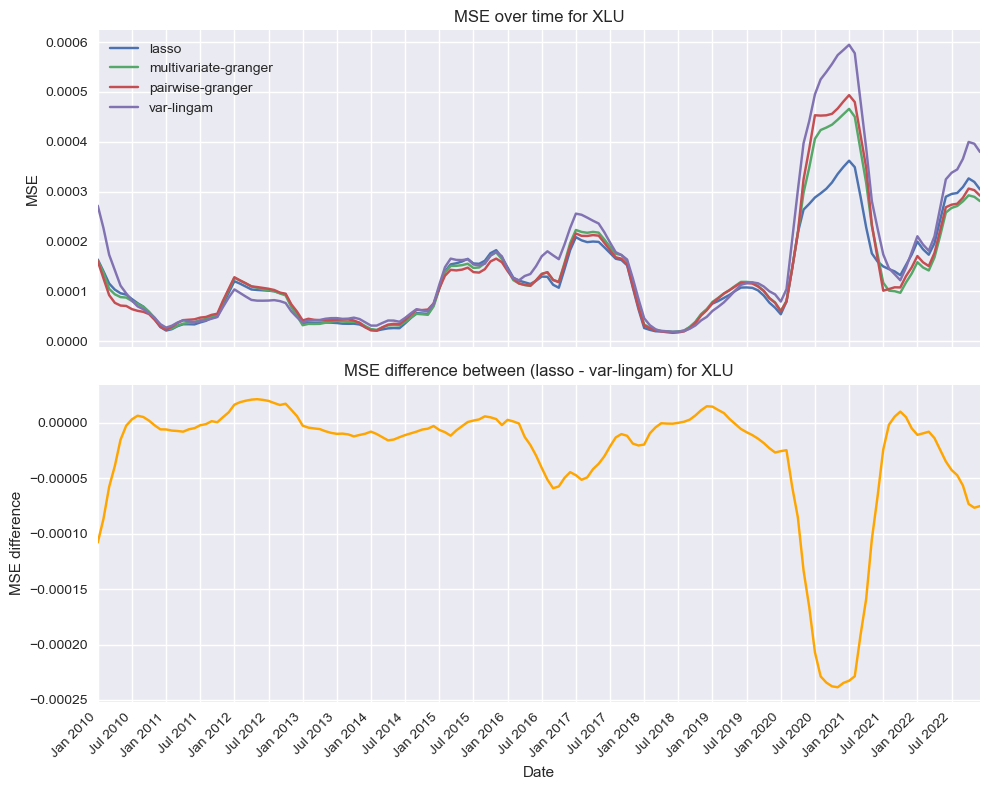

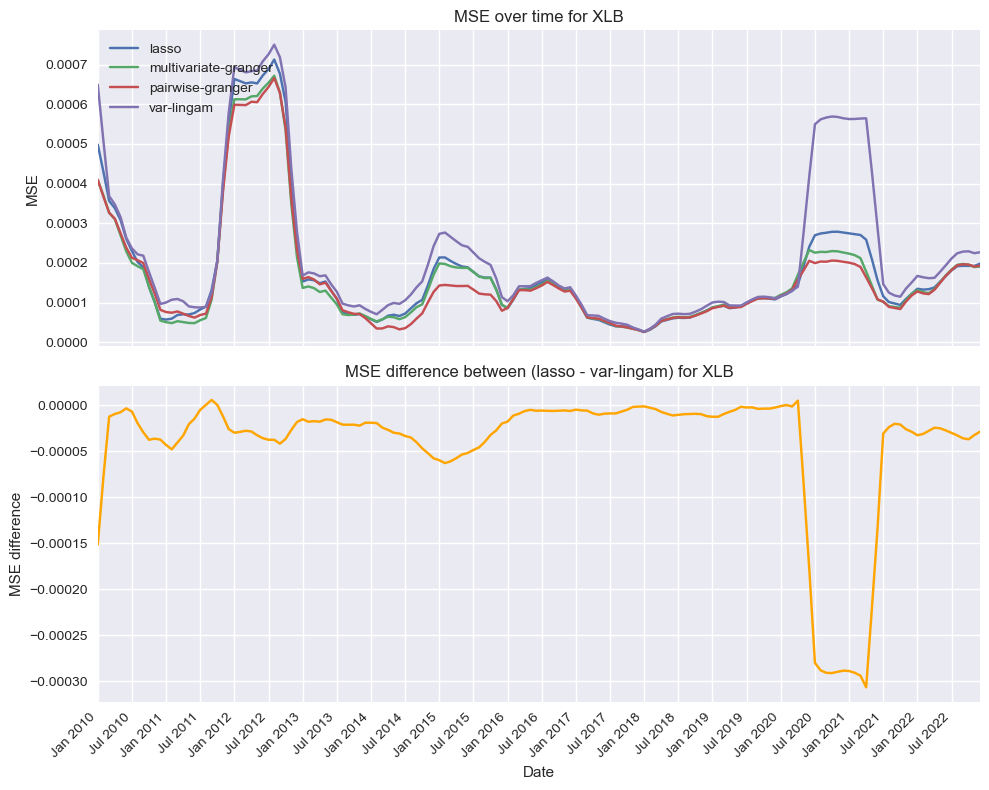

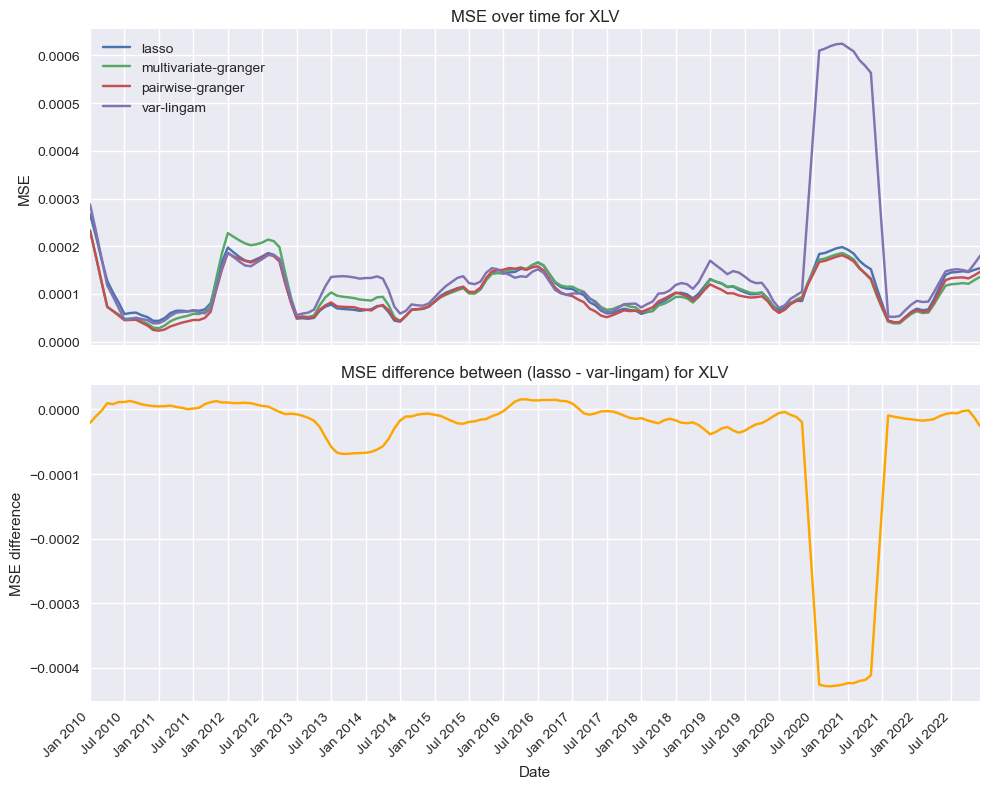

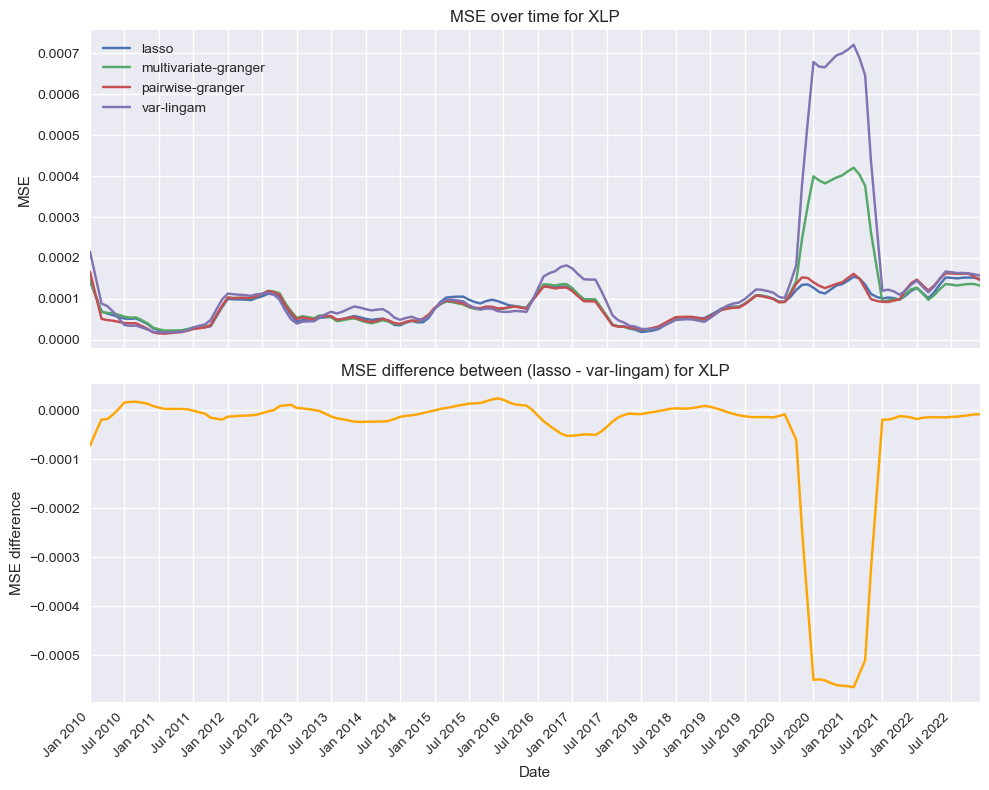

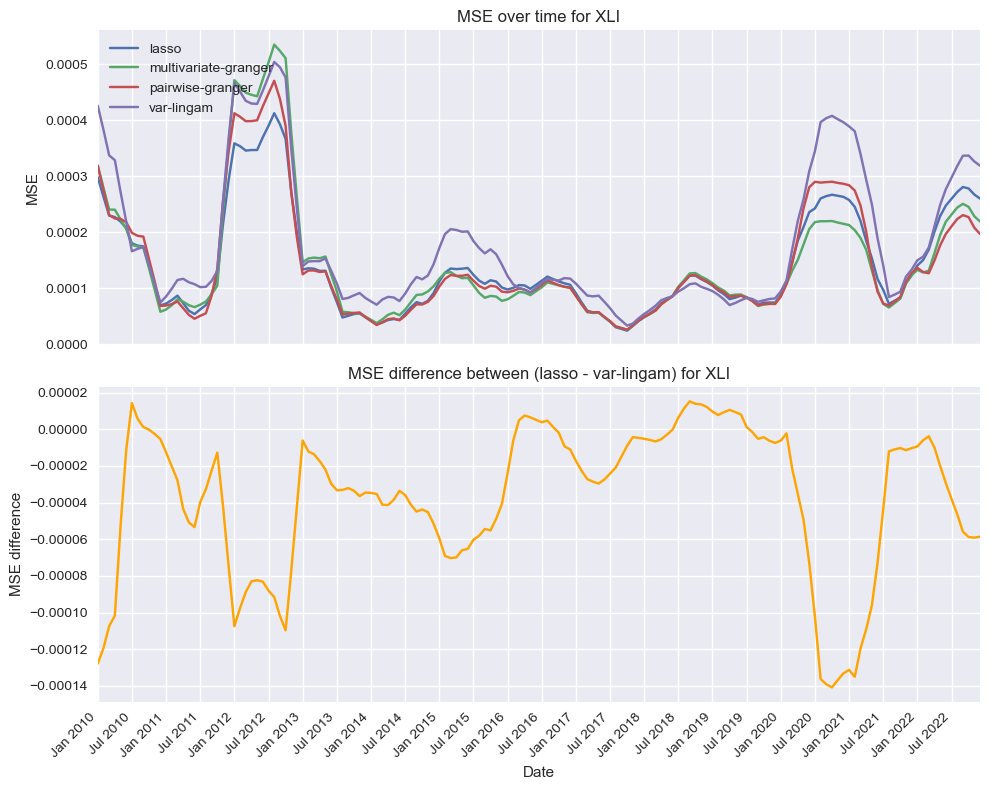

In [37]:
# SPY, XLP, XLK, XLY, XLF, XLB, XLI 

for etf in all_rolling_metrics_df["etf"].unique():
    etf_rolling_metrics_df = all_rolling_metrics_df.loc[(all_rolling_metrics_df["etf"] == etf)].pivot_table(index=["date"], columns=["fs"], values=["value"])
    etf_rolling_metrics_df.columns = etf_rolling_metrics_df.columns.droplevel()
    etf_rolling_metrics_df = etf_rolling_metrics_df.rolling(3).mean().loc["2010-01-01":]
    etf_rolling_metrics_df["diff_lasso_var-lingam"] = etf_rolling_metrics_df["lasso"] - etf_rolling_metrics_df["var-lingam"]

    # Plotting
    fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # Plotting on the upper subplot
    etf_rolling_metrics_df.drop(["diff_lasso_var-lingam"], axis=1).plot(ax=axs[0])
    axs[0].set_title(f'MSE over time for {etf}')
    axs[0].set_ylabel('MSE')
    axs[0].legend(loc='upper left')

    # Plotting on the lower subplot
    etf_rolling_metrics_df["diff_lasso_var-lingam"].plot(ax=axs[1], color='orange')
    axs[1].set_title(f'MSE difference between (lasso - var-lingam) for {etf}')
    axs[1].set_xlabel('Date')
    axs[1].set_ylabel('MSE difference')

    # Adding months and years to the index of the plot
    tick_positions = etf_rolling_metrics_df.index[::6]  # Show every 6th date
    axs[1].set_xticks(tick_positions)
    axs[1].set_xticklabels(tick_positions.strftime('%b %Y'), rotation=45, ha='right')

    # Adjust layout for better visualization
    plt.tight_layout()

    # Show the plot
    plt.show()

In [23]:
all_metrics_df.sort_values(by="mse", ascending=True)

mse       mae  mse_2020  mae_2020  stability
fs                   etf                                                   
pairwise-granger     XLP  0.000091  0.006951  0.000151  0.010354   0.142857
                     XLV  0.000095  0.007163  0.000193  0.011091   0.000000
multivariate-granger XLV  0.000099  0.007352  0.000198  0.011148   0.000000
                     XLP  0.000100  0.007050  0.000436  0.014205   0.090909
                     SPY  0.000108  0.007358  0.000218  0.011965   0.000000
                     XLU  0.000130  0.008333  0.000496  0.017047   0.000000
                     XLK  0.000140  0.008429  0.000320  0.015402   0.083333
pairwise-granger     XLK  0.000140  0.008430  0.000344  0.016258   0.166667
lasso                XLP  0.000142  0.007402  0.000147  0.010049   0.416667
multivariate-granger XLY  0.000156  0.008469  0.000468  0.014970   0.000000
pairwise-granger     XLY  0.000158  0.008694  0.000342  0.013965   0.000000
                     XLB  0.000162  0.009369  0.000220  0.011926   0.000000
var-lingam           XLP  0.000164  0.008257  0.000760  0.017402   1.000000
multivariate-granger XLB  0.000165  0.009334  0.000245  0.012229   0.000000
var-lingam           XLV  0.000225  0.009132  0.000677  0.016180   1.000000
lasso                XLK  0.000250  0.009590  0.000411  0.016851   0.307692
multivariate-granger XLF  0.000254  0.010530  0.000723  0.022546   0.062500
lasso                XLV  0.000264  0.008214  0.000212  0.010437   0.333333
                     XLB  0.000265  0.010485  0.000301  0.014353   0.142857
var-lingam           XLY  0.000267  0.010265  0.000528  0.015670   1.000000
pairwise-granger     SPY  0.000313  0.008166  0.000209  0.012132   0.111111
lasso                SPY  0.000320  0.008442  0.000202  0.011218   0.200000
var-lingam           SPY  0.000411  0.009477  0.000392  0.014322   1.000000
lasso                XLY  0.000432  0.009266  0.000153  0.009398   0.090909
var-lingam           XLK  0.000553  0.011935  0.000575  0.016553   1.000000
                     XLF  0.000596  0.013227  0.001204  0.025350   1.000000
pairwise-granger     XLF  0.000617  0.011819  0.000764  0.023529   0.000000
lasso                XLU  0.000641  0.009966  0.000385  0.016460   0.142857
                     XLF  0.000657  0.011959  0.000368  0.016069   0.187500
                     XLI  0.000658  0.010074  0.000287  0.014110   0.214286
multivariate-granger XLI  0.000694  0.009930  0.000235  0.012587   0.000000
pairwise-granger     XLI  0.000702  0.009939  0.000313  0.014394   0.000000
                     XLU  0.000718  0.009900  0.000526  0.015819   0.000000
var-lingam           XLU  0.000758  0.011282  0.000643  0.019838   1.000000
                     XLB  0.000761  0.012509  0.000614  0.018225   1.000000
lasso                XLE  0.001326  0.013508  0.000615  0.018712   0.285714
pairwise-granger     XLE  0.001358  0.013345  0.000602  0.017971   0.000000
multivariate-granger XLE  0.001563  0.013647  0.000571  0.018312   0.000000
var-lingam           XLI  0.002637  0.013048  0.000429  0.016341   1.000000
                     XLE  0.006507  0.017920  0.000726  0.021831   1.000000

In [24]:
all_metrics_df.sort_values(by="mae", ascending=True)

mse       mae  mse_2020  mae_2020  stability
fs                   etf                                                   
pairwise-granger     XLP  0.000091  0.006951  0.000151  0.010354   0.142857
multivariate-granger XLP  0.000100  0.007050  0.000436  0.014205   0.090909
pairwise-granger     XLV  0.000095  0.007163  0.000193  0.011091   0.000000
multivariate-granger XLV  0.000099  0.007352  0.000198  0.011148   0.000000
                     SPY  0.000108  0.007358  0.000218  0.011965   0.000000
lasso                XLP  0.000142  0.007402  0.000147  0.010049   0.416667
pairwise-granger     SPY  0.000313  0.008166  0.000209  0.012132   0.111111
lasso                XLV  0.000264  0.008214  0.000212  0.010437   0.333333
var-lingam           XLP  0.000164  0.008257  0.000760  0.017402   1.000000
multivariate-granger XLU  0.000130  0.008333  0.000496  0.017047   0.000000
                     XLK  0.000140  0.008429  0.000320  0.015402   0.083333
pairwise-granger     XLK  0.000140  0.008430  0.000344  0.016258   0.166667
lasso                SPY  0.000320  0.008442  0.000202  0.011218   0.200000
multivariate-granger XLY  0.000156  0.008469  0.000468  0.014970   0.000000
pairwise-granger     XLY  0.000158  0.008694  0.000342  0.013965   0.000000
var-lingam           XLV  0.000225  0.009132  0.000677  0.016180   1.000000
lasso                XLY  0.000432  0.009266  0.000153  0.009398   0.090909
multivariate-granger XLB  0.000165  0.009334  0.000245  0.012229   0.000000
pairwise-granger     XLB  0.000162  0.009369  0.000220  0.011926   0.000000
var-lingam           SPY  0.000411  0.009477  0.000392  0.014322   1.000000
lasso                XLK  0.000250  0.009590  0.000411  0.016851   0.307692
pairwise-granger     XLU  0.000718  0.009900  0.000526  0.015819   0.000000
multivariate-granger XLI  0.000694  0.009930  0.000235  0.012587   0.000000
pairwise-granger     XLI  0.000702  0.009939  0.000313  0.014394   0.000000
lasso                XLU  0.000641  0.009966  0.000385  0.016460   0.142857
                     XLI  0.000658  0.010074  0.000287  0.014110   0.214286
var-lingam           XLY  0.000267  0.010265  0.000528  0.015670   1.000000
lasso                XLB  0.000265  0.010485  0.000301  0.014353   0.142857
multivariate-granger XLF  0.000254  0.010530  0.000723  0.022546   0.062500
var-lingam           XLU  0.000758  0.011282  0.000643  0.019838   1.000000
pairwise-granger     XLF  0.000617  0.011819  0.000764  0.023529   0.000000
var-lingam           XLK  0.000553  0.011935  0.000575  0.016553   1.000000
lasso                XLF  0.000657  0.011959  0.000368  0.016069   0.187500
var-lingam           XLB  0.000761  0.012509  0.000614  0.018225   1.000000
                     XLI  0.002637  0.013048  0.000429  0.016341   1.000000
                     XLF  0.000596  0.013227  0.001204  0.025350   1.000000
pairwise-granger     XLE  0.001358  0.013345  0.000602  0.017971   0.000000
lasso                XLE  0.001326  0.013508  0.000615  0.018712   0.285714
multivariate-granger XLE  0.001563  0.013647  0.000571  0.018312   0.000000
var-lingam           XLE  0.006507  0.017920  0.000726  0.021831   1.000000

In [25]:
all_metrics_df.sort_values(by="stability", ascending=False)

mse       mae  mse_2020  mae_2020  stability
fs                   etf                                                   
var-lingam           XLI  0.002637  0.013048  0.000429  0.016341   1.000000
                     XLP  0.000164  0.008257  0.000760  0.017402   1.000000
                     XLV  0.000225  0.009132  0.000677  0.016180   1.000000
                     XLB  0.000761  0.012509  0.000614  0.018225   1.000000
                     XLU  0.000758  0.011282  0.000643  0.019838   1.000000
                     XLY  0.000267  0.010265  0.000528  0.015670   1.000000
                     SPY  0.000411  0.009477  0.000392  0.014322   1.000000
                     XLF  0.000596  0.013227  0.001204  0.025350   1.000000
                     XLK  0.000553  0.011935  0.000575  0.016553   1.000000
                     XLE  0.006507  0.017920  0.000726  0.021831   1.000000
lasso                XLP  0.000142  0.007402  0.000147  0.010049   0.416667
                     XLV  0.000264  0.008214  0.000212  0.010437   0.333333
                     XLK  0.000250  0.009590  0.000411  0.016851   0.307692
                     XLE  0.001326  0.013508  0.000615  0.018712   0.285714
                     XLI  0.000658  0.010074  0.000287  0.014110   0.214286
                     SPY  0.000320  0.008442  0.000202  0.011218   0.200000
                     XLF  0.000657  0.011959  0.000368  0.016069   0.187500
pairwise-granger     XLK  0.000140  0.008430  0.000344  0.016258   0.166667
lasso                XLU  0.000641  0.009966  0.000385  0.016460   0.142857
                     XLB  0.000265  0.010485  0.000301  0.014353   0.142857
pairwise-granger     XLP  0.000091  0.006951  0.000151  0.010354   0.142857
                     SPY  0.000313  0.008166  0.000209  0.012132   0.111111
multivariate-granger XLP  0.000100  0.007050  0.000436  0.014205   0.090909
lasso                XLY  0.000432  0.009266  0.000153  0.009398   0.090909
multivariate-granger XLK  0.000140  0.008429  0.000320  0.015402   0.083333
                     XLF  0.000254  0.010530  0.000723  0.022546   0.062500
                     XLY  0.000156  0.008469  0.000468  0.014970   0.000000
pairwise-granger     XLI  0.000702  0.009939  0.000313  0.014394   0.000000
multivariate-granger XLE  0.001563  0.013647  0.000571  0.018312   0.000000
pairwise-granger     XLV  0.000095  0.007163  0.000193  0.011091   0.000000
multivariate-granger XLU  0.000130  0.008333  0.000496  0.017047   0.000000
pairwise-granger     XLB  0.000162  0.009369  0.000220  0.011926   0.000000
                     XLU  0.000718  0.009900  0.000526  0.015819   0.000000
                     XLY  0.000158  0.008694  0.000342  0.013965   0.000000
                     XLF  0.000617  0.011819  0.000764  0.023529   0.000000
multivariate-granger SPY  0.000108  0.007358  0.000218  0.011965   0.000000
                     XLI  0.000694  0.009930  0.000235  0.012587   0.000000
                     XLV  0.000099  0.007352  0.000198  0.011148   0.000000
                     XLB  0.000165  0.009334  0.000245  0.012229   0.000000
pairwise-granger     XLE  0.001358  0.013345  0.000602  0.017971   0.000000

In [26]:
all_metrics_df.sort_values(by="mse_2020", ascending=True)

,,mse,mae,mse_2020,mae_2020,stability
fs,etf,,,,,
lasso,XLP,0.000142,0.007402,0.000147,0.010049,0.416667
pairwise-granger,XLP,0.000091,0.006951,0.000151,0.010354,0.142857
lasso,XLY,0.000432,0.009266,0.000153,0.009398,0.090909
pairwise-granger,XLV,0.000095,0.007163,0.000193,0.011091,0.000000
multivariate-granger,XLV,0.000099,0.007352,0.000198,0.011148,0.000000
lasso,SPY,0.000320,0.008442,0.000202,0.011218,0.200000
pairwise-granger,SPY,0.000313,0.008166,0.000209,0.012132,0.111111
lasso,XLV,0.000264,0.008214,0.000212,0.010437,0.333333
multivariate-granger,SPY,0.000108,0.007358,0.000218,0.011965,0.000000


In [27]:
all_metrics_df.sort_values(by="mse", ascending=True)

mse       mae  mse_2020  mae_2020  stability
fs                   etf                                                   
pairwise-granger     XLP  0.000091  0.006951  0.000151  0.010354   0.142857
                     XLV  0.000095  0.007163  0.000193  0.011091   0.000000
multivariate-granger XLV  0.000099  0.007352  0.000198  0.011148   0.000000
                     XLP  0.000100  0.007050  0.000436  0.014205   0.090909
                     SPY  0.000108  0.007358  0.000218  0.011965   0.000000
                     XLU  0.000130  0.008333  0.000496  0.017047   0.000000
                     XLK  0.000140  0.008429  0.000320  0.015402   0.083333
pairwise-granger     XLK  0.000140  0.008430  0.000344  0.016258   0.166667
lasso                XLP  0.000142  0.007402  0.000147  0.010049   0.416667
multivariate-granger XLY  0.000156  0.008469  0.000468  0.014970   0.000000
pairwise-granger     XLY  0.000158  0.008694  0.000342  0.013965   0.000000
                     XLB  0.000162  0.009369  0.000220  0.011926   0.000000
var-lingam           XLP  0.000164  0.008257  0.000760  0.017402   1.000000
multivariate-granger XLB  0.000165  0.009334  0.000245  0.012229   0.000000
var-lingam           XLV  0.000225  0.009132  0.000677  0.016180   1.000000
lasso                XLK  0.000250  0.009590  0.000411  0.016851   0.307692
multivariate-granger XLF  0.000254  0.010530  0.000723  0.022546   0.062500
lasso                XLV  0.000264  0.008214  0.000212  0.010437   0.333333
                     XLB  0.000265  0.010485  0.000301  0.014353   0.142857
var-lingam           XLY  0.000267  0.010265  0.000528  0.015670   1.000000
pairwise-granger     SPY  0.000313  0.008166  0.000209  0.012132   0.111111
lasso                SPY  0.000320  0.008442  0.000202  0.011218   0.200000
var-lingam           SPY  0.000411  0.009477  0.000392  0.014322   1.000000
lasso                XLY  0.000432  0.009266  0.000153  0.009398   0.090909
var-lingam           XLK  0.000553  0.011935  0.000575  0.016553   1.000000
                     XLF  0.000596  0.013227  0.001204  0.025350   1.000000
pairwise-granger     XLF  0.000617  0.011819  0.000764  0.023529   0.000000
lasso                XLU  0.000641  0.009966  0.000385  0.016460   0.142857
                     XLF  0.000657  0.011959  0.000368  0.016069   0.187500
                     XLI  0.000658  0.010074  0.000287  0.014110   0.214286
multivariate-granger XLI  0.000694  0.009930  0.000235  0.012587   0.000000
pairwise-granger     XLI  0.000702  0.009939  0.000313  0.014394   0.000000
                     XLU  0.000718  0.009900  0.000526  0.015819   0.000000
var-lingam           XLU  0.000758  0.011282  0.000643  0.019838   1.000000
                     XLB  0.000761  0.012509  0.000614  0.018225   1.000000
lasso                XLE  0.001326  0.013508  0.000615  0.018712   0.285714
pairwise-granger     XLE  0.001358  0.013345  0.000602  0.017971   0.000000
multivariate-granger XLE  0.001563  0.013647  0.000571  0.018312   0.000000
var-lingam           XLI  0.002637  0.013048  0.000429  0.016341   1.000000
                     XLE  0.006507  0.017920  0.000726  0.021831   1.000000

<AxesSubplot:xlabel='stability', ylabel='mae'>

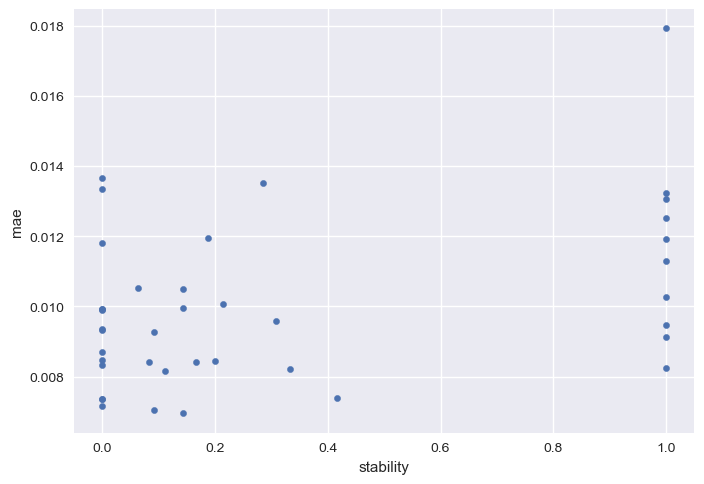

In [28]:
all_metrics_df.plot.scatter(y="mae", x="stability")

<AxesSubplot:xlabel='stability', ylabel='mae_2020'>

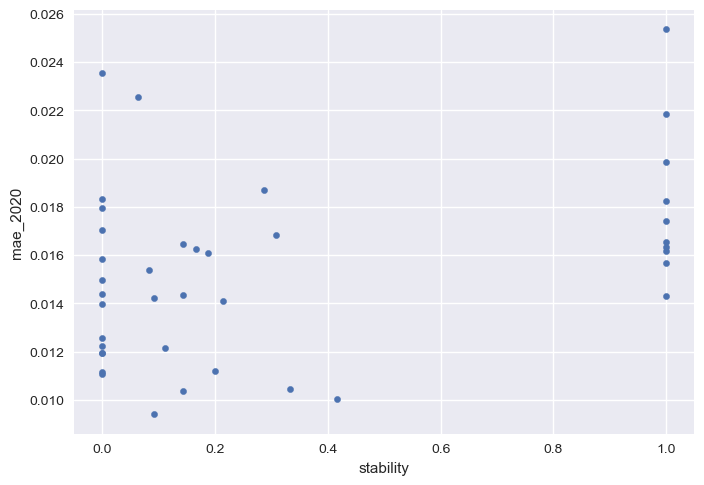

In [29]:
all_metrics_df.plot.scatter(y="mae_2020", x="stability")

<AxesSubplot:xlabel='stability', ylabel='mse'>

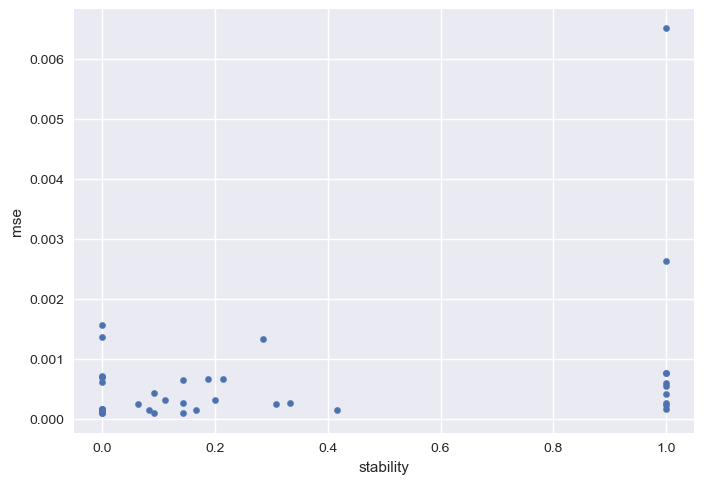

In [30]:
all_metrics_df.plot.scatter(y="mse", x="stability")

<AxesSubplot:xlabel='stability', ylabel='mse_2020'>

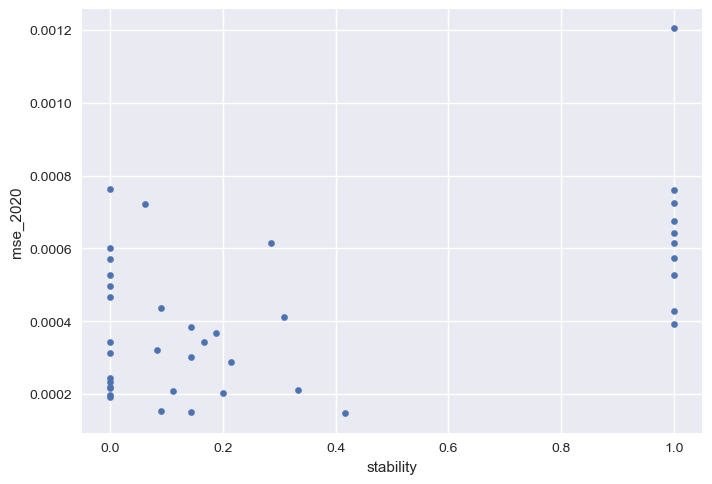

In [31]:
all_metrics_df.plot.scatter(y="mse_2020", x="stability")